In [1]:
!pip install catboost xgboost pyswarm --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


In [2]:
# === Imports ===
import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from pyswarm import pso

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_2017_2020 = pd.read_csv("/content/drive/MyDrive/Network Maintenace - With & without maintenace/encoded-data/Treatment-encoded-dataset-2017-2020/df_encoded_2017_2020.csv")

In [4]:
df_2017_2020.shape

(5110, 27)

In [5]:
df_2017_2020.head(10)

AADT_mean_x  AADT_Single_Unit_mean_x  AADT_Combination_mean_x  \
0       1395.0                    156.0                     54.0   
1      22429.0                    767.0                   4163.0   
2      22429.0                    767.0                   4163.0   
3      26595.0                    878.0                    186.0   
4       1964.0                     92.0                      6.0   
5       2182.0                    175.0                    242.0   
6      19601.0                    568.0                    196.0   
7      14674.0                    264.0                    205.0   
8      35793.0                   1432.0                    107.0   
9      10559.0                    443.0                     74.0   

   Future_AADT_mean_x  IRI_mean_x  Thickness_Rigid_mean_x  \
0              1590.0        82.0                     0.0   
1             22430.0       101.0                    10.0   
2             22430.0       128.0                    10.0   
3             37230.0       172.8                     0.0   
4              2750.0       287.0                     0.0   
5              3060.0       245.5                     0.0   
6             27440.0       196.5                     0.0   
7             27000.0       219.8                     0.0   
8             50110.0       209.9                     0.0   
9             19430.0       359.0                     0.0   

   Thickness_Flexible_mean_x  Base_Thickness_mean_x  F_System_mode  \
0                        6.0                   15.0              5   
1                        0.0                    6.0              1   
2                        0.0                    6.0              1   
3                        3.0                    6.0              3   
4                        3.0                    8.0              3   
5                        3.0                    8.0              3   
6                        3.0                    8.0              3   
7                        3.0                    8.0              3   
8                        3.0                    6.0              3   
9                        3.0                    8.0              3   

   Surface_Type_mode  ...  FRZ_IDX_x  TEMP_AVG_x  PRECIPITATION_x  Age_x  \
0                  6  ...     1081.5         5.6           1089.7     32   
1                  3  ...      896.3         7.3            979.6      8   
2                  3  ...      896.3         7.3            979.6      8   
3                  2  ...        3.7        19.6            933.1     24   
4                  2  ...        1.1        20.3            894.7     72   
5                  2  ...        9.0        18.7           1015.6     73   
6                  2  ...        9.0        18.7           1015.6     73   
7                  2  ...        0.0        23.0            534.0     20   
8                  2  ...        0.0        23.0            534.0     18   
9                  2  ...        0.0        23.0            534.0     45   

   Urban_Type_rural  Urban_Type_small urban  Urban_Type_urban  \
0               1.0                     0.0               0.0   
1               1.0                     0.0               0.0   
2               0.0                     1.0               0.0   
3               0.0                     0.0               1.0   
4               0.0                     0.0               1.0   
5               0.0                     0.0               1.0   
6               0.0                     0.0               1.0   
7               0.0                     0.0               1.0   
8               0.0                     0.0               1.0   
9               0.0                     0.0               1.0   

   Treatment_type_Resurfacing  Treatment_type_Thick Layers  \
0                         0.0                          0.0   
1                         0.0                          1.0   
2                         0.0                          1.0   
3         

In [6]:
df_2017_2020.isnull().sum()

AADT_mean_x                       0
AADT_Single_Unit_mean_x           0
AADT_Combination_mean_x           0
Future_AADT_mean_x                0
IRI_mean_x                        0
Thickness_Rigid_mean_x            0
Thickness_Flexible_mean_x         0
Base_Thickness_mean_x             0
F_System_mode                     0
Surface_Type_mode                 0
Base_Type_mode_x                  0
Rutting_mean_x                    0
Cracking_Percent_mean_x           0
Faulting_mean_x                   0
Last_Overlay_Thickness_mean_x     0
IRI_mean_y                        0
RHU_AV_x                         16
FRZ_IDX_x                        16
TEMP_AVG_x                       16
PRECIPITATION_x                  16
Age_x                             0
Urban_Type_rural                  0
Urban_Type_small urban            0
Urban_Type_urban                  0
Treatment_type_Resurfacing        0
Treatment_type_Thick Layers       0
Treatment_type_Thin Layers        0
dtype: int64

In [7]:
df = df_2017_2020.dropna()

In [8]:
df.shape

(5094, 27)

In [9]:
df.columns

Index(['AADT_mean_x', 'AADT_Single_Unit_mean_x', 'AADT_Combination_mean_x',
       'Future_AADT_mean_x', 'IRI_mean_x', 'Thickness_Rigid_mean_x',
       'Thickness_Flexible_mean_x', 'Base_Thickness_mean_x', 'F_System_mode',
       'Surface_Type_mode', 'Base_Type_mode_x', 'Rutting_mean_x',
       'Cracking_Percent_mean_x', 'Faulting_mean_x',
       'Last_Overlay_Thickness_mean_x', 'IRI_mean_y', 'RHU_AV_x', 'FRZ_IDX_x',
       'TEMP_AVG_x', 'PRECIPITATION_x', 'Age_x', 'Urban_Type_rural',
       'Urban_Type_small urban', 'Urban_Type_urban',
       'Treatment_type_Resurfacing', 'Treatment_type_Thick Layers',
       'Treatment_type_Thin Layers'],
      dtype='object')

In [10]:
df.drop(['Last_Overlay_Thickness_mean_x'], axis=1, inplace=True)

/tmp/ipython-input-705596893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Last_Overlay_Thickness_mean_x'], axis=1, inplace=True)


In [11]:
df.isnull().sum()

AADT_mean_x                    0
AADT_Single_Unit_mean_x        0
AADT_Combination_mean_x        0
Future_AADT_mean_x             0
IRI_mean_x                     0
Thickness_Rigid_mean_x         0
Thickness_Flexible_mean_x      0
Base_Thickness_mean_x          0
F_System_mode                  0
Surface_Type_mode              0
Base_Type_mode_x               0
Rutting_mean_x                 0
Cracking_Percent_mean_x        0
Faulting_mean_x                0
IRI_mean_y                     0
RHU_AV_x                       0
FRZ_IDX_x                      0
TEMP_AVG_x                     0
PRECIPITATION_x                0
Age_x                          0
Urban_Type_rural               0
Urban_Type_small urban         0
Urban_Type_urban               0
Treatment_type_Resurfacing     0
Treatment_type_Thick Layers    0
Treatment_type_Thin Layers     0
dtype: int64

In [12]:
df.columns

Index(['AADT_mean_x', 'AADT_Single_Unit_mean_x', 'AADT_Combination_mean_x',
       'Future_AADT_mean_x', 'IRI_mean_x', 'Thickness_Rigid_mean_x',
       'Thickness_Flexible_mean_x', 'Base_Thickness_mean_x', 'F_System_mode',
       'Surface_Type_mode', 'Base_Type_mode_x', 'Rutting_mean_x',
       'Cracking_Percent_mean_x', 'Faulting_mean_x', 'IRI_mean_y', 'RHU_AV_x',
       'FRZ_IDX_x', 'TEMP_AVG_x', 'PRECIPITATION_x', 'Age_x',
       'Urban_Type_rural', 'Urban_Type_small urban', 'Urban_Type_urban',
       'Treatment_type_Resurfacing', 'Treatment_type_Thick Layers',
       'Treatment_type_Thin Layers'],
      dtype='object')

In [13]:
num_dupes = df.duplicated(keep=False).sum()
print(f"Duplicate rows in df (all columns considered): {num_dupes}")

Duplicate rows in df (all columns considered): 8


In [14]:
# --- Remove duplicate rows across all columns ---
initial_rows = len(df)

df.drop_duplicates(inplace=True)   # modifies df in place

print(f"Duplicates removed: {initial_rows - len(df)}")
print(f"New DataFrame shape: {df.shape}")


Duplicates removed: 4
New DataFrame shape: (5090, 26)


/tmp/ipython-input-3110374706.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)   # modifies df in place


In [15]:
df.shape

(5090, 26)

In [16]:
X = df.drop(columns=['IRI_mean_y'])  # Drop target column to keep 21 input features
y = df[['IRI_mean_y']]               # Target stays (N, 1)

In [17]:
y.shape

(5090, 1)

In [18]:
print(X.shape)  # Should be (4060, 21)
print(y.shape)  # Should be (4060, 1)

(5090, 25)
(5090, 1)


In [19]:
type(y)

pandas.core.frame.DataFrame

In [20]:
# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
print(X_test.shape)

(764, 25)


In [22]:
print(X_train.shape)  # Should be [num_samples, 26]
print(y_train.shape)  # Should be [num_samples, 1] or [num_samples]

(3563, 25)
(3563, 1)


In [23]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_val_scaled = scaler_x.transform(X_val)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

X_train_unscaled_df = X_train.copy().reset_index(drop=True)
X_test_unscaled_df = X_test.copy().reset_index(drop=True)

In [24]:
# === XGBoost instead of ANN ===
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# ---- Grid search exactly as given ----
xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42, verbosity=0),
    {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1]
    },
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit on the scaled data (target flattened)
xgb_grid.fit(X_train_scaled, y_train_scaled.ravel())
best_xgb = xgb_grid.best_estimator_
print("Best XGB params:", xgb_grid.best_params_)


Best XGB params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [25]:
# ================================
# 🔁 Predict on TRAIN and TEST
# ================================
# Train predictions (still on scaled input features)
y_pred_train_scaled = best_xgb.predict(X_train_scaled).reshape(-1, 1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_true_train = y_train.values

# Test predictions
y_pred_test_scaled = best_xgb.predict(X_test_scaled).reshape(-1, 1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_true_test = y_test.values


In [26]:
# ================================
# 📊 Overall metrics (same function you used)
# ================================
def calculate_metrics(y_true, y_pred, name="Model"):
    n = len(y_true)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)
    mae = np.mean(np.abs(y_true - y_pred))
    epsilon = 1e-10
    mape = (100 / n) * np.sum(np.abs((y_true - y_pred) / (y_true + epsilon)))
    vaf = (1 - np.var(y_true - y_pred) / np.var(y_true)) * 100
    rsr = rmse / np.sqrt(np.mean((y_true - np.mean(y_true))**2))
    wmap = (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100
    m20 = np.sum(np.abs(y_true - y_pred) <= 0.2 * np.abs(y_true))
    a20index = m20 / n

    print(f"🔹 {name}:")
    print(f"   R²       = {r2:.4f}")
    print(f"   RMSE     = {rmse:.4f}")
    print(f"   MAE      = {mae:.4f}")
    print(f"   MAPE     = {mape:.4f}%")
    print(f"   VAF      = {vaf:.4f}%")
    print(f"   RSR      = {rsr:.4f}")
    print(f"   WMAPE    = {wmap:.4f}%")
    print(f"   a20index = {a20index:.4f}")
    return rmse, r2, mae, mape, vaf, rsr, wmap, a20index

xgb_metrics_train = calculate_metrics(y_true_train, y_pred_train, name="XGBoost • Train")
xgb_metrics_test  = calculate_metrics(y_true_test , y_pred_test , name="XGBoost • Test")

🔹 XGBoost • Train:
   R²       = 0.8181
   RMSE     = 20.2235
   MAE      = 14.2707
   MAPE     = 19.2166%
   VAF      = 81.8149%
   RSR      = 0.4264
   WMAPE    = 17.4242%
   a20index = 0.6831
🔹 XGBoost • Test:
   R²       = 0.7747
   RMSE     = 24.0606
   MAE      = 16.0283
   MAPE     = 20.1947%
   VAF      = 77.5328%
   RSR      = 0.4746
   WMAPE    = 19.3364%
   a20index = 0.6453


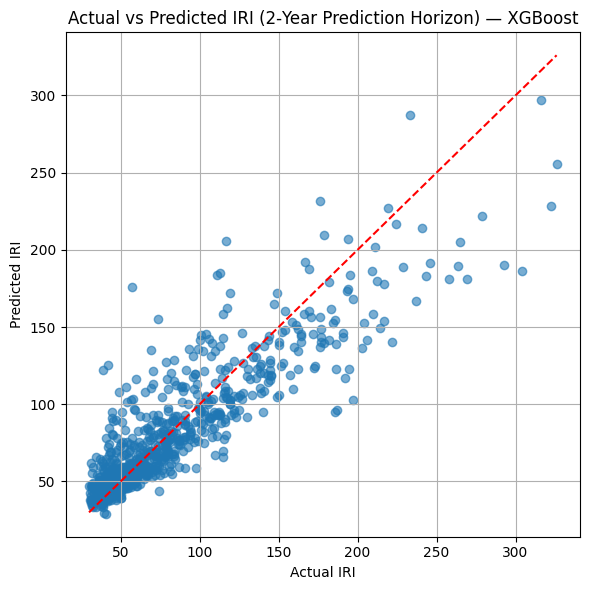

In [27]:
# ==============================
# 📊 Scatter Plot (2‑year horizon)
# ==============================
plt.figure(figsize=(6, 6))
plt.scatter(y_true_test, y_pred_test, alpha=0.6)
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], 'r--')
plt.xlabel("Actual IRI")
plt.ylabel("Predicted IRI")
plt.title("Actual vs Predicted IRI (2‑Year Prediction Horizon) — XGBoost")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# ======================================================
# 👉 Attach predictions to TRAIN/TEST frames (like ANN)
# ======================================================
X_train_unscaled_df = X_train_unscaled_df.copy().reset_index(drop=True)
X_test_unscaled_df  = X_test_unscaled_df.copy().reset_index(drop=True)

X_train_unscaled_df['y_true'] = y_true_train.flatten()
X_train_unscaled_df['y_pred'] = y_pred_train.flatten()

X_test_unscaled_df['Actual_IRI']    = y_true_test.flatten()
X_test_unscaled_df['Predicted_IRI'] = y_pred_test.flatten()
X_test_unscaled_df['y_true']        = y_true_test.flatten()
X_test_unscaled_df['y_pred']        = y_pred_test.flatten()

# Optional: save evaluated test set (XGBoost)
X_test_unscaled_df.to_csv(os.path.join("xgb_evaluated_test_set_with_predictions.csv"), index=False)

In [29]:
# ============================================
# 📈 Per‑treatment metrics (TRAIN & TEST)
# ============================================
def evaluate_subset_metrics(df):
    n = len(df['y_true'])
    rmse = np.sqrt(np.mean((df['y_true']- df['y_pred'])**2))
    ss_res = np.sum((df['y_true']- df['y_pred'])**2)
    ss_tot = np.sum((df['y_true'] - np.mean(df['y_true']))**2)
    r2 = 1 - (ss_res / ss_tot)
    mae = np.mean(np.abs(df['y_true']- df['y_pred']))
    epsilon = 1e-10
    mape = (100 / n) * np.sum(np.abs((df['y_true']- df['y_pred']) / (df['y_true'] + epsilon)))
    vaf = (1 - np.var(df['y_true']- df['y_pred']) / np.var(df['y_true'])) * 100
    rsr = rmse / np.sqrt(np.mean((df['y_true'] - np.mean(df['y_true']))**2))
    wmap = (np.sum(np.abs(df['y_true']- df['y_pred'])) / np.sum(np.abs(df['y_true']))) * 100
    m20 = np.sum(np.abs(df['y_true']- df['y_pred']) <= 0.2 * np.abs(df['y_true']))
    a20index = m20 / n
    return rmse, r2, mae, mape, vaf, rsr, wmap, a20index

treatments = {
    'Thin Layers': 'Treatment_type_Thin Layers',
    'Thick Layers': 'Treatment_type_Thick Layers',
    'Resurfacing': 'Treatment_type_Resurfacing',
}

print("\n📌 TRAIN SET RESULTS (by treatment):")
for name, col in treatments.items():
    sub = X_train_unscaled_df[X_train_unscaled_df[col] == 1]
    if len(sub) > 0:
        rmse, r2, mae, mape, vaf, rsr, wmap, a20index = evaluate_subset_metrics(sub)
        print(f"[TRAIN] {name:12} — R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, WMAPE: {wmap:.2f}%, n={len(sub)}")
    else:
        print(f"[TRAIN] {name:12} — No data found.")

print("\n📌 TEST SET RESULTS (by treatment):")
for name, col in treatments.items():
    sub = X_test_unscaled_df[X_test_unscaled_df[col] == 1]
    if len(sub) > 0:
        rmse, r2, mae, mape, vaf, rsr, wmap, a20index = evaluate_subset_metrics(sub)
        print(f"[TEST]  {name:12} — R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, WMAPE: {wmap:.2f}%, n={len(sub)}")
    else:
        print(f"[TEST]  {name:12} — No data found.")


📌 TRAIN SET RESULTS (by treatment):
[TRAIN] Thin Layers  — R²: 0.8157, MAE: 15.2578, RMSE: 21.5372, WMAPE: 17.40%, n=2552
[TRAIN] Thick Layers — R²: 0.7607, MAE: 11.8499, RMSE: 16.5076, WMAPE: 18.36%, n=814
[TRAIN] Resurfacing  — R²: 0.8442, MAE: 11.4857, RMSE: 16.1948, WMAPE: 14.61%, n=197

📌 TEST SET RESULTS (by treatment):
[TEST]  Thin Layers  — R²: 0.7743, MAE: 16.9673, RMSE: 25.5173, WMAPE: 18.99%, n=572
[TEST]  Thick Layers — R²: 0.6886, MAE: 13.3853, RMSE: 19.0926, WMAPE: 21.53%, n=146
[TEST]  Resurfacing  — R²: 0.6407, MAE: 12.7404, RMSE: 19.0077, WMAPE: 18.66%, n=46


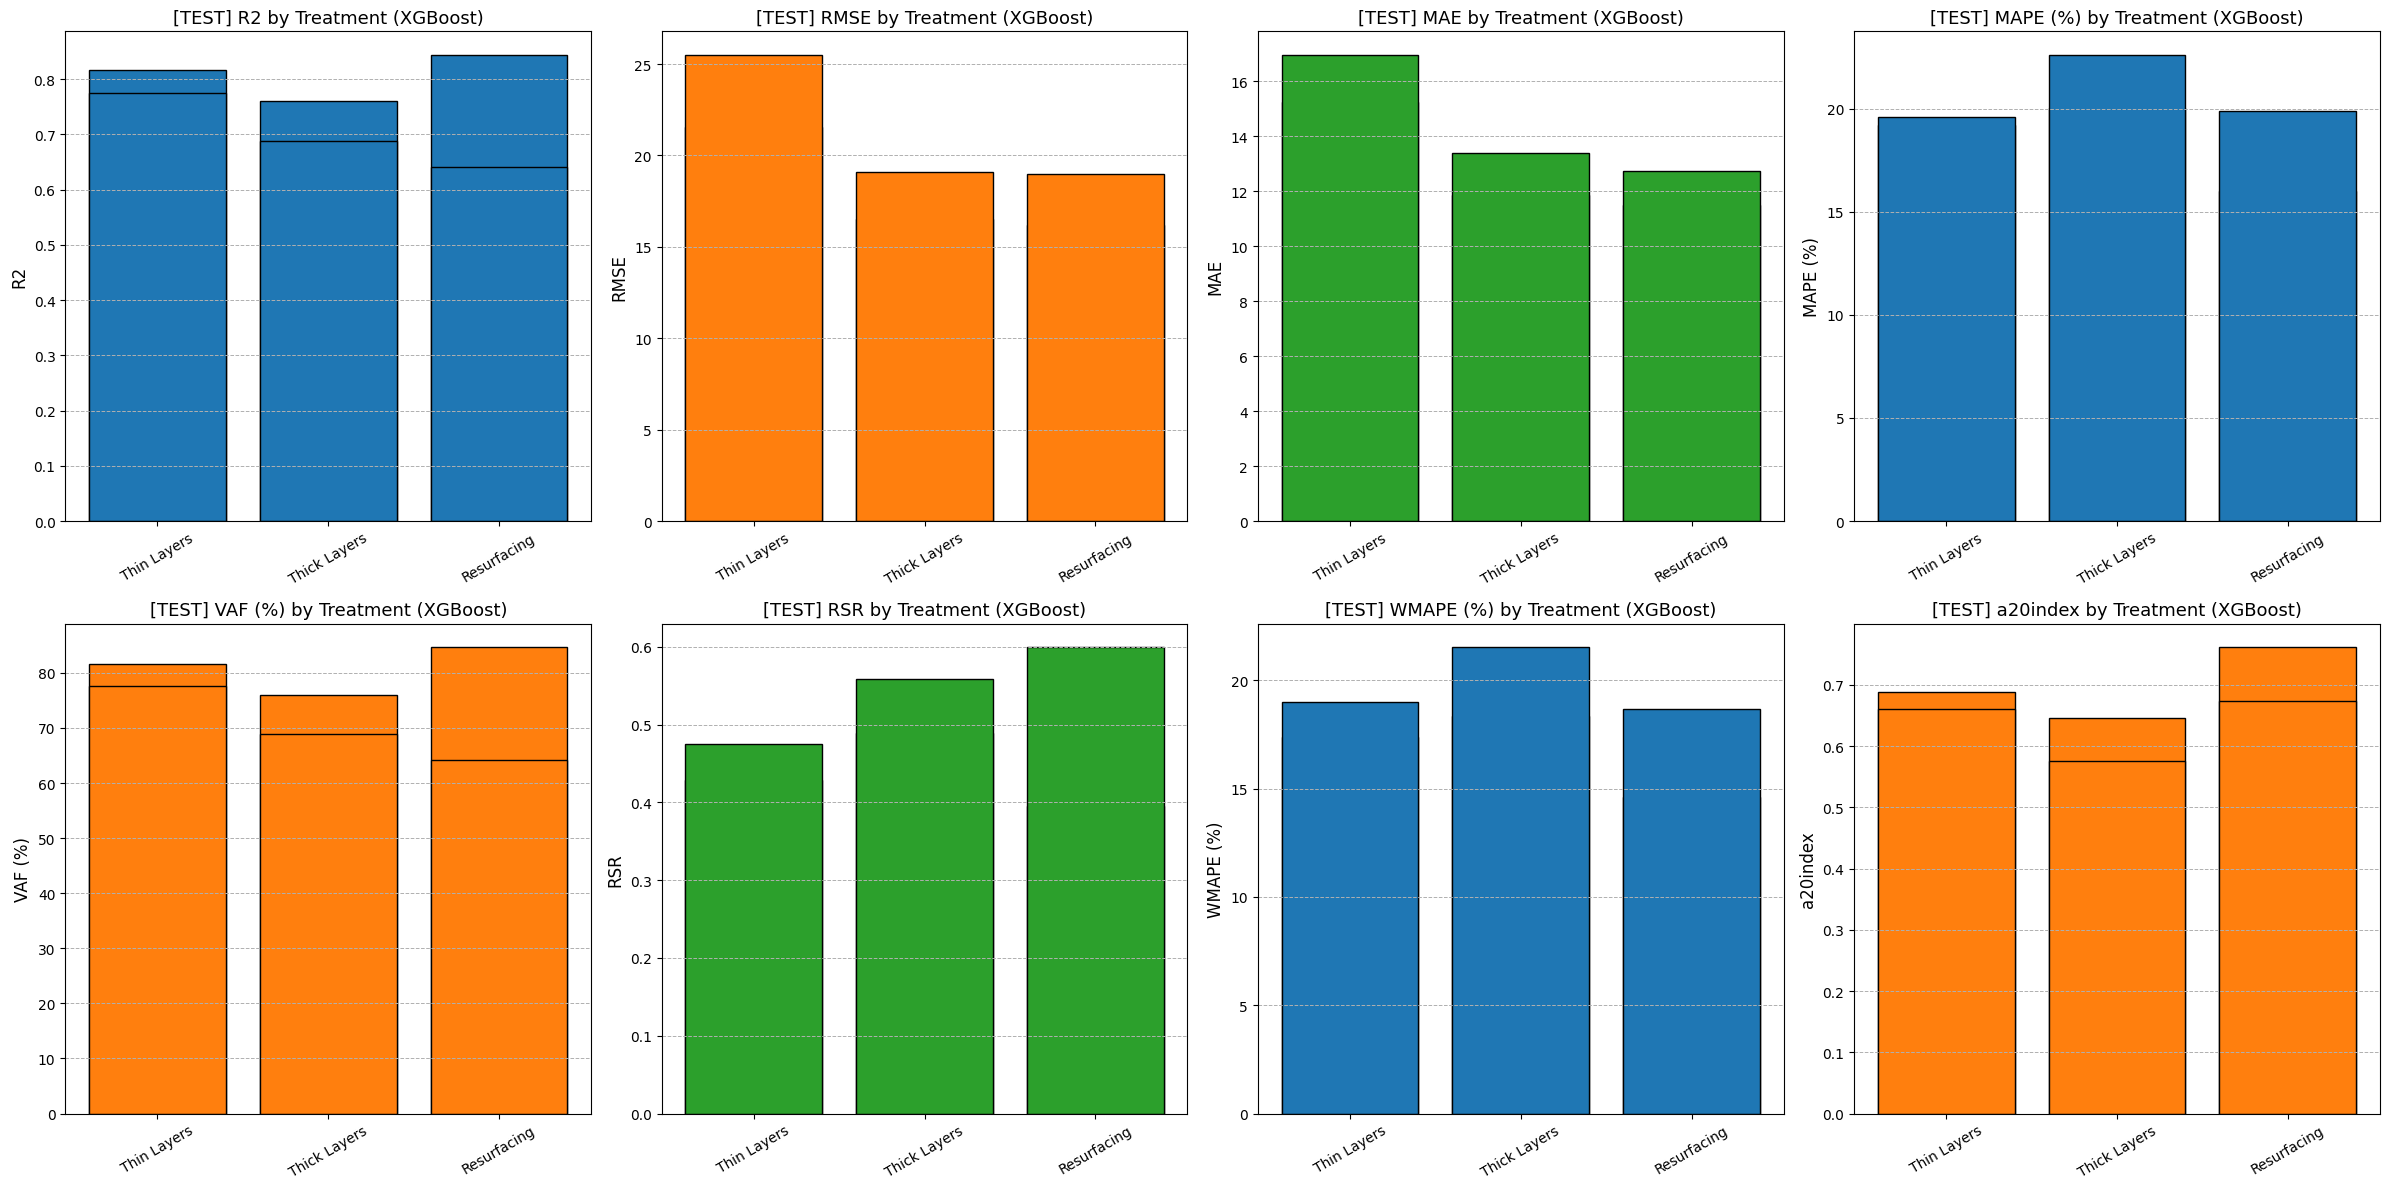

In [30]:
# =======================================================
# 📊 Collect metrics tables (Train/Test) for plotting
# =======================================================
def collect_metrics(df, label):
    records = []
    for name, col in treatments.items():
        sub = df[df[col] == 1]
        if len(sub) > 0:
            rmse, r2, mae, mape, vaf, rsr, wmap, a20index = evaluate_subset_metrics(sub)
            records.append({
                'Treatment': name,
                'R2': r2,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE (%)': mape,
                'VAF (%)': vaf,
                'RSR': rsr,
                'WMAPE (%)': wmap,
                'a20index': a20index,
                'Set': label
            })
    return pd.DataFrame(records)

df_train_plot = collect_metrics(X_train_unscaled_df, 'Train')
df_test_plot  = collect_metrics(X_test_unscaled_df,  'Test')

metrics = ['R2', 'RMSE', 'MAE', 'MAPE (%)', 'VAF (%)', 'RSR', 'WMAPE (%)', 'a20index']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, metric in enumerate(metrics):
    axes[i].bar(df_train_plot['Treatment'], df_train_plot[metric],
                color=colors[i % len(colors)], edgecolor='black')
    axes[i].set_title(f"[TRAIN] {metric} by Treatment (XGBoost)", fontsize=13)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].grid(axis='y', linestyle='--', linewidth=0.7)

for i, metric in enumerate(metrics):
    axes[i].bar(df_test_plot['Treatment'], df_test_plot[metric],
                color=colors[i % len(colors)], edgecolor='black')
    axes[i].set_title(f"[TEST] {metric} by Treatment (XGBoost)", fontsize=13)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].grid(axis='y', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

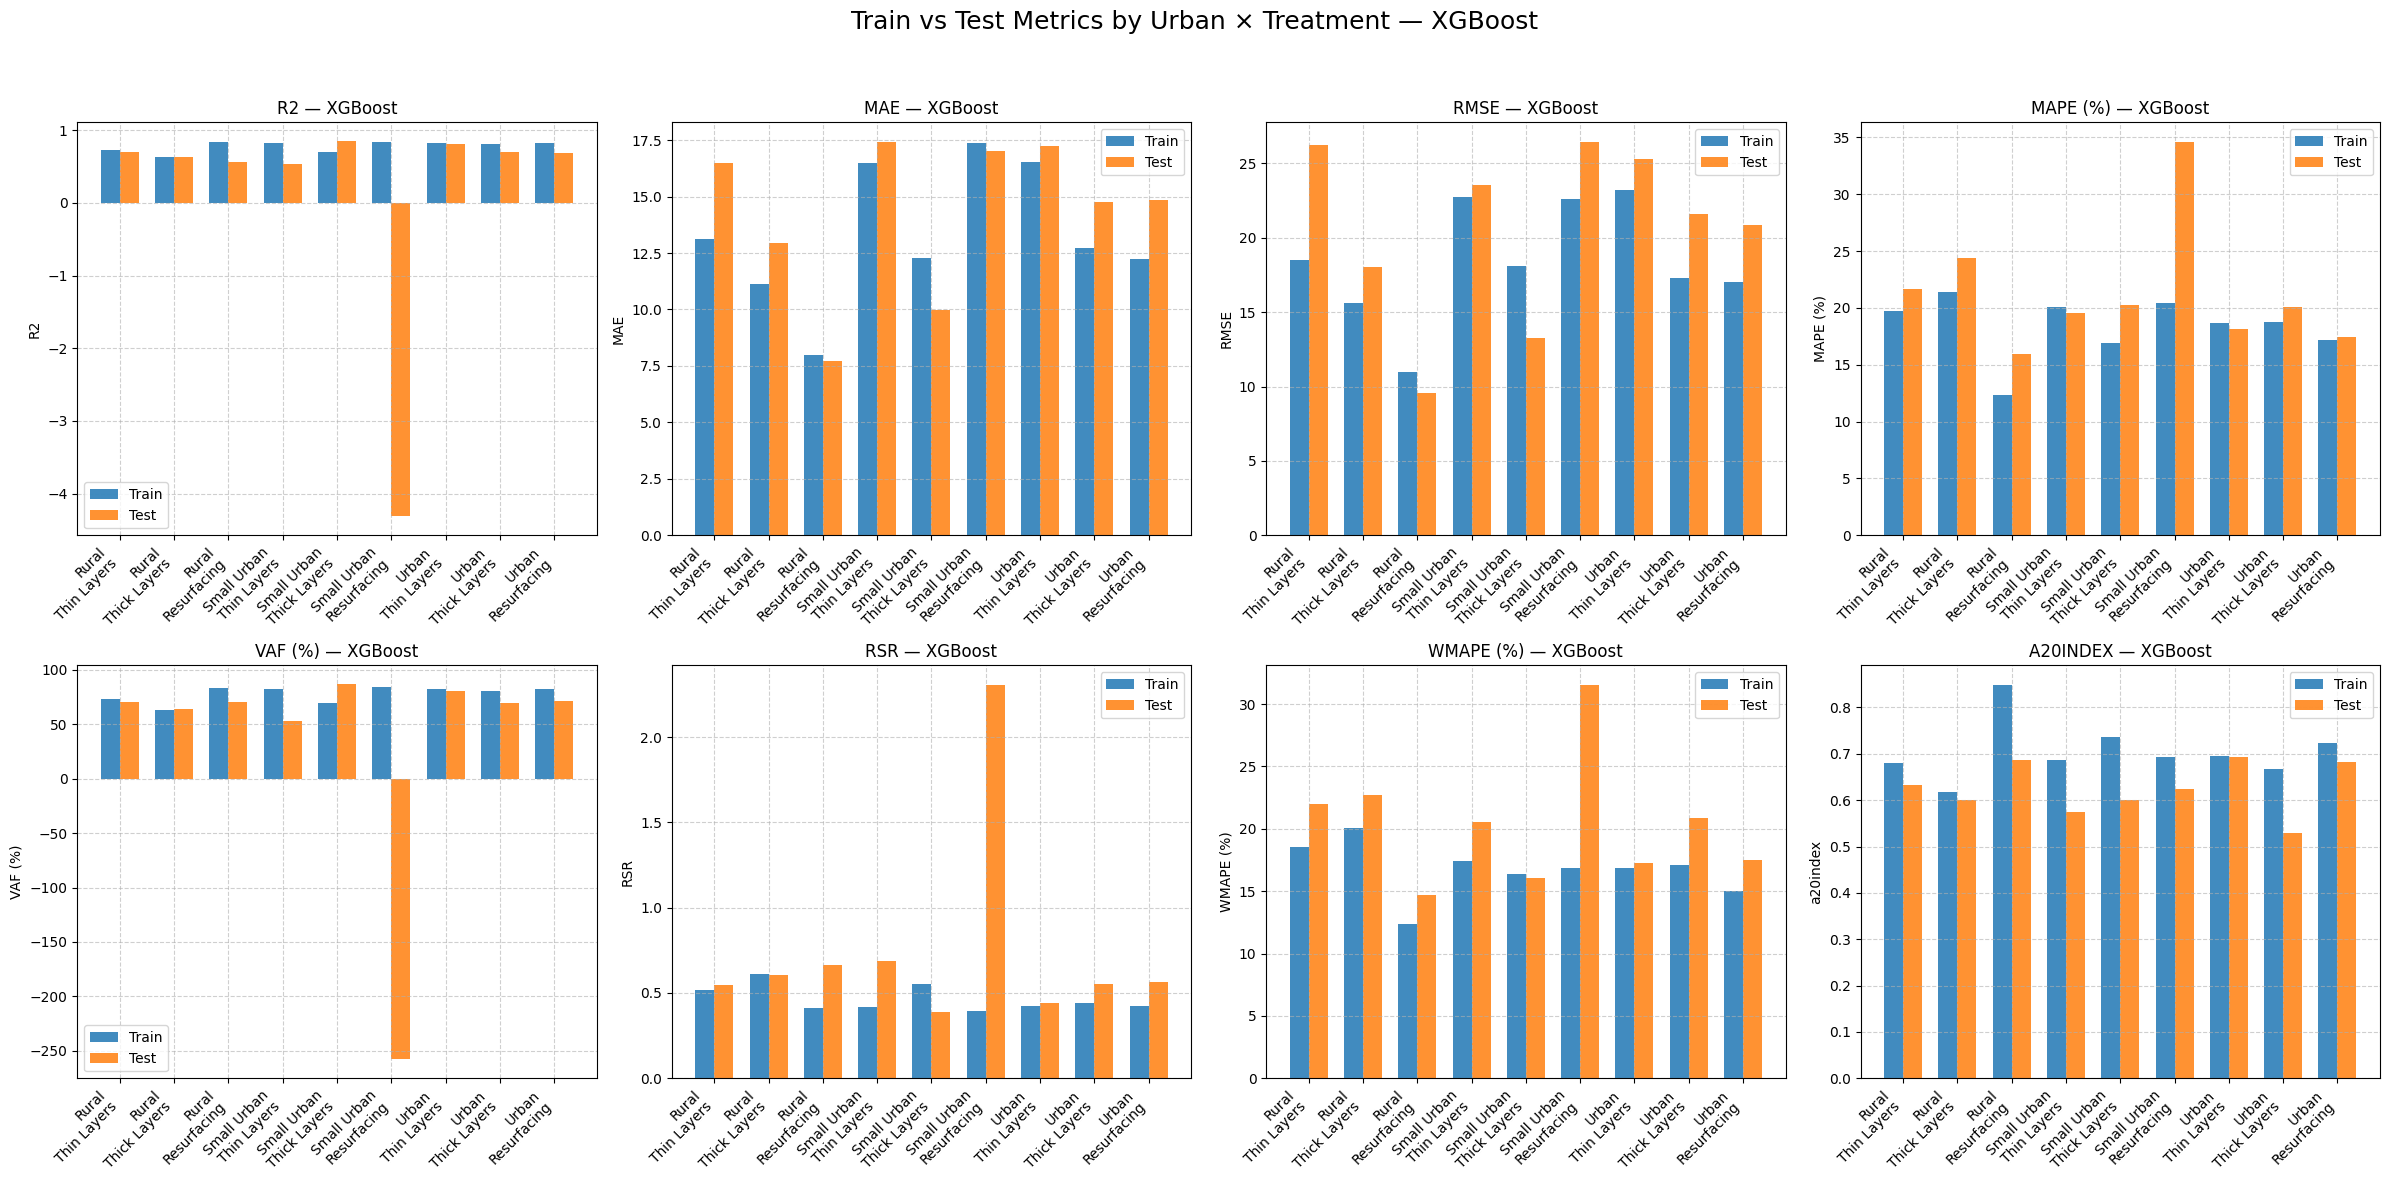

In [31]:
# ============================================================
# 🔀 Urban × Treatment breakdown (Train vs Test) — XGBoost
# ============================================================
urban_types = {
    'Rural': 'Urban_Type_rural',
    'Small Urban': 'Urban_Type_small urban',
    'Urban': 'Urban_Type_urban',
}

def eval_full(df):
    errors = df['y_true'] - df['y_pred']
    mse = mean_squared_error(df['y_true'], df['y_pred'])
    mae = mean_absolute_error(df['y_true'], df['y_pred'])
    rmse = np.sqrt(mse)
    ss_res = np.sum(errors**2)
    ss_tot = np.sum((df['y_true'] - np.mean(df['y_true']))**2)
    r2 = 1 - (ss_res / ss_tot)
    epsilon = 1e-10
    mape = (100 / len(df)) * np.sum(np.abs(errors / (df['y_true'] + epsilon)))
    vaf = (1 - np.var(errors) / np.var(df['y_true'])) * 100
    rsr = rmse / np.sqrt(np.mean((df['y_true'] - np.mean(df['y_true']))**2))
    wmap = (np.sum(np.abs(errors)) / np.sum(np.abs(df['y_true']))) * 100
    m20 = np.sum(np.abs(errors) <= 0.2 * np.abs(df['y_true']))
    a20index = m20 / len(df)
    return r2, mae, rmse, mape, vaf, rsr, wmap, a20index

def collect_results(df, set_name):
    out = []
    for u_name, u_col in urban_types.items():
        u_df = df[df[u_col] == 1]
        for t_name, t_col in treatments.items():
            sub = u_df[u_df[t_col] == 1]
            if len(sub) > 0:
                r2, mae, rmse, mape, vaf, rsr, wmap, a20 = eval_full(sub)
                out.append({
                    'Urban': u_name, 'Treatment': t_name, 'Set': set_name,
                    'R2': r2, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape,
                    'VAF (%)': vaf, 'RSR': rsr, 'WMAPE (%)': wmap, 'a20index': a20
                })
    return pd.DataFrame(out)

df_train_metrics = collect_results(X_train_unscaled_df, 'Train')
df_test_metrics  = collect_results(X_test_unscaled_df,  'Test')
df_all_metrics   = pd.concat([df_train_metrics, df_test_metrics], ignore_index=True)

# Plot grouped bars Train vs Test for each metric across Urban×Treatment
metrics = ['R2', 'MAE', 'RMSE', 'MAPE (%)', 'VAF (%)', 'RSR', 'WMAPE (%)', 'a20index']
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 12))
axes = axes.flatten()

combos = [(u, t) for u in urban_types for t in treatments]
x_labels = [f"{u}\n{t}" for u, t in combos]
x = np.arange(len(combos))
width = 0.35

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    train_vals, test_vals = [], []
    for u, t in combos:
        tr = df_all_metrics[(df_all_metrics['Urban'] == u) &
                            (df_all_metrics['Treatment'] == t) &
                            (df_all_metrics['Set'] == 'Train')][metric]
        te = df_all_metrics[(df_all_metrics['Urban'] == u) &
                            (df_all_metrics['Treatment'] == t) &
                            (df_all_metrics['Set'] == 'Test')][metric]
        train_vals.append(tr.values[0] if not tr.empty else np.nan)
        test_vals.append(te.values[0] if not te.empty else np.nan)

    ax.bar(x - width/2, train_vals, width=width, label='Train', alpha=0.85)
    ax.bar(x + width/2, test_vals , width=width, label='Test' , alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.set_title(f"{metric.upper()} — XGBoost")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

plt.suptitle("Train vs Test Metrics by Urban × Treatment — XGBoost", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
